In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename));

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/.DS_Store
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/.DS_Store
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1947_bacteria_4876.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1946_bacteria_4875.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1952_bacteria_4883.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1954_bacteria_4886.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1951_bacteria_4882.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1946_bacteria_4874.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1949_bacteria_4880.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/.DS_Store
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/per

In [2]:
import random
random.seed(123)

import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning)

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

import cv2
import datetime
import itertools

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K

from PIL import Image
import keras
from keras.preprocessing.image import load_img, ImageDataGenerator, img_to_array
from keras import models
from keras import layers
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from keras import optimizers
from keras import regularizers
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.applications import VGG19

from sklearn.metrics import accuracy_score, confusion_matrix, plot_confusion_matrix
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import auc,roc_curve,roc_auc_score

In [3]:
#set Adam optimizer with a learning rate of 1e-4 or 0.0001
optimizer = keras.optimizers.Adam(learning_rate = 1e-5)

#define the callbacks
early_stopping = [EarlyStopping(monitor = 'val_loss', patience = 10),
                 ModelCheckpoint(filepath = 'best_model.h5', monitor = 'val_loss', save_best_only = True)]

# Data Visualization

In [4]:
#define path to the data directory
base_dir = '../input/chest-xray-pneumonia/chest_xray/'
train_dir = base_dir + 'train/'
test_dir = base_dir + 'test/'
val_dir = base_dir + 'val/'

#train dataset
train_normal = train_dir + 'NORMAL/'
train_pneu = train_dir + 'PNEUMONIA/'

#test dataset
test_normal = test_dir + 'NORMAL/'
test_pneu = test_dir + 'PNEUMONIA/'

#validation dataset
val_normal = val_dir + 'NORMAL/'
val_pneu = val_dir + 'PNEUMONIA/'

In [5]:
#check for number of images in each dataset
#normal condition
print('Train Normal:', len(os.listdir(train_normal)))
print('Test Normal:', len(os.listdir(test_normal)))
print('Val Normal:', len(os.listdir(val_normal)))
print('\n')

#pneumonia condition
print('Train Pneumonia:', len(os.listdir(train_pneu)))
print('Test Pneumonia:', len(os.listdir(test_pneu)))
print('Val Pneumonia:', len(os.listdir(val_pneu)))

Train Normal: 1341
Test Normal: 234
Val Normal: 8


Train Pneumonia: 3875
Test Pneumonia: 390
Val Pneumonia: 8


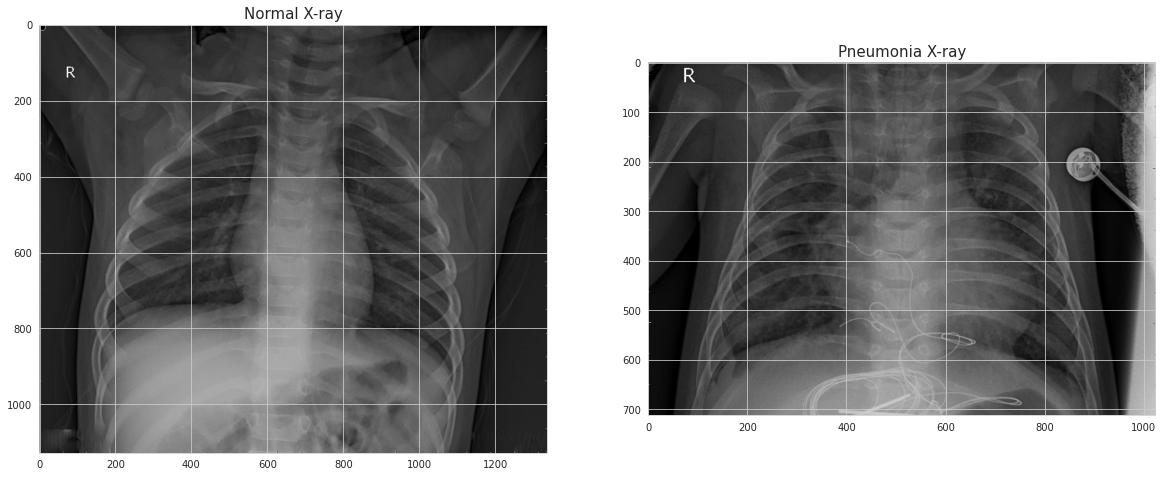

In [6]:
from PIL import Image
from keras.preprocessing.image import load_img
import matplotlib.pyplot as plt

normal = Image.open(train_normal + os.listdir(train_normal)[0])
pneu = Image.open(train_pneu + os.listdir(train_pneu)[0])

fig = plt.figure(figsize = (20, 20))

ax1 = fig.add_subplot(1, 2, 1)
ax1.set_title('Normal X-ray', fontsize = 15)
plt.imshow(normal, cmap = 'gray')

ax2 = fig.add_subplot(1, 2, 2)
ax2.set_title('Pneumonia X-ray', fontsize = 15)
plt.imshow(pneu, cmap = 'gray')

In [7]:
#save
plt.savefig('X-ray.png')

<Figure size 432x288 with 0 Axes>

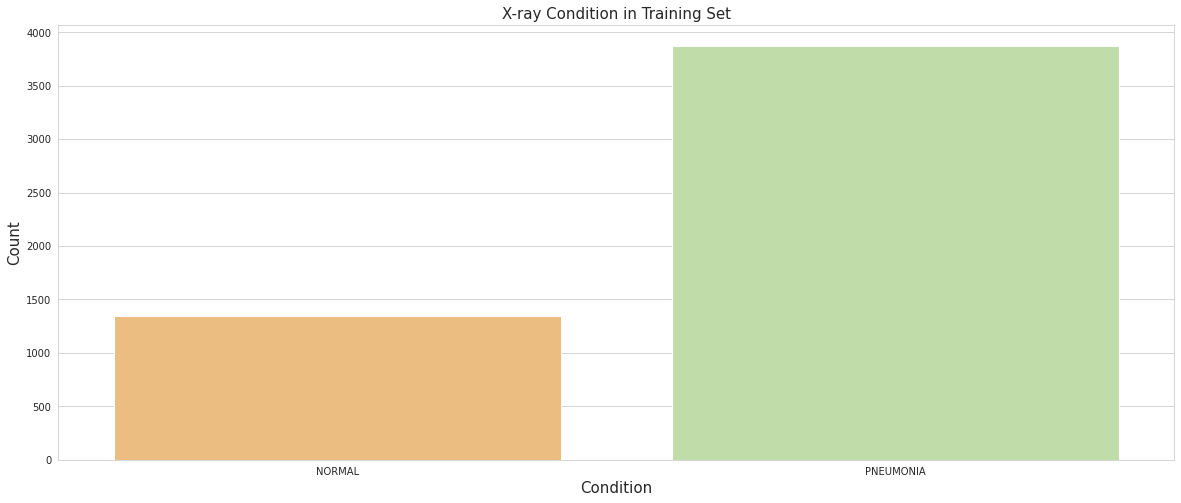

In [8]:
#visualize each class
import seaborn as sns

plt.figure(figsize = (20, 8))
sns.barplot(x = ['NORMAL', 'PNEUMONIA'], 
            y = [len(os.listdir(train_normal)), len(os.listdir(train_pneu))],
            palette = 'Spectral')
plt.xlabel('Condition', fontsize = 15)
plt.ylabel('Count', fontsize = 15)
plt.title('X-ray Condition in Training Set', fontsize = 15);

There is a class imbalance issue.

# Data Augmentation
Data augmentation is typically always a necessary step when using a small dataset. 

In [9]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from keras.preprocessing.image import ImageDataGenerator, img_to_array

#augment train and validation dataset to prevent overfitting by increasing number of images
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   
                                   #randomly rotate images
                                   rotation_range = 40,
                                   
                                   #randomly shear angles
                                   shear_range = 0.2,
                                   
                                   #randomly zoom images
                                   zoom_range = 0.2,
                                   
                                   #randomly shift images
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   
                                   # randomly flip images
                                   horizontal_flip = True,
                                   
                                   fill_mode = 'nearest')

val_datagen = ImageDataGenerator(rescale = 1./255,
                                 rotation_range = 40,
                                 shear_range = 0.2,
                                 zoom_range = 0.2,
                                 width_shift_range = 0.2,
                                 height_shift_range = 0.2,
                                 horizontal_flip = True,
                                 fill_mode = 'nearest')

#rescale test dataset without augmentation since real world data is not augmented
test_datagen = ImageDataGenerator(rescale = 1./255)

#get all the data in the directory with specified batch sizes and image dimensions
train_generator = train_datagen.flow_from_directory(
        #target directory
        train_dir,
    
        #resize to 150x150
        target_size = (150, 150),
    
        #size batches of data
        batch_size = 32,
    
        #since we use binary_crossentropy loss, we need binary labels
        class_mode = 'binary')

test_generator = test_datagen.flow_from_directory(test_dir,
                                                  target_size = (150, 150),
                                                  batch_size = 32,
                                                  class_mode = 'binary',
                                                  shuffle = False)

val_generator = val_datagen.flow_from_directory(val_dir,
                                                target_size = (150, 150),
                                                batch_size = 32,
                                                class_mode = 'binary')

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


In [10]:
#code from https://www.kaggle.com/rafetcan/pneumonia-normal-cnn-model

import cv2
def picture_separation(folder):
    
    '''divide the mixed pictures into NORMAL and PNEUMONIA & add labels to these'''
    
    X = []
    y = []
    image_list = []

    for foldername in os.listdir(folder):
        if not foldername.startswith('.'):
            if foldername == "NORMAL":
                label = 0
            elif foldername == "PNEUMONIA":
                label = 1
            else:
                label = 2
                
            for image_filename in os.listdir(folder + "/"+ foldername):
                img_file = cv2.imread(folder + "/" + foldername + '/' + image_filename,0)               
                

                if img_file is not None:
                    img = cv2.resize(img_file,(64,64))
                    img_arr = img_to_array(img) / 255
                    X.append(img_arr)
                    y.append(label)
                    image_list.append(foldername + '/' + image_filename)
                                        
    X = np.asarray(X)
    y = np.asarray(y)
    
    return X, y, image_list

In [11]:
#get train dataset
X_train, y_train, img_train = picture_separation(train_dir)

train_df = pd.DataFrame(img_train, columns = ["images"])
train_df["target"] = y_train

#preview
train_df.head()

,images,target
0,PNEUMONIA/person1180_virus_2010.jpeg,1
1,PNEUMONIA/person1230_virus_2081.jpeg,1
2,PNEUMONIA/person1513_virus_2632.jpeg,1
3,PNEUMONIA/person124_virus_238.jpeg,1
4,PNEUMONIA/person746_virus_1369.jpeg,1


In [12]:
#get validation dataset
X_val, y_val, img_val = picture_separation(val_dir)

val_df = pd.DataFrame(img_val, columns = ["images"])
val_df["target"] = y_val

#preview
val_df.head()

,images,target
0,PNEUMONIA/person1947_bacteria_4876.jpeg,1
1,PNEUMONIA/person1946_bacteria_4875.jpeg,1
2,PNEUMONIA/person1952_bacteria_4883.jpeg,1
3,PNEUMONIA/person1954_bacteria_4886.jpeg,1
4,PNEUMONIA/person1951_bacteria_4882.jpeg,1


In [13]:
#get test dataset
X_test, y_test, img_test = picture_separation(test_dir)

test_df = pd.DataFrame(img_test, columns = ["images"])
test_df["target"] = y_test

#preview
test_df.head()

,images,target
0,PNEUMONIA/person1676_virus_2892.jpeg,1
1,PNEUMONIA/person1650_virus_2852.jpeg,1
2,PNEUMONIA/person22_virus_55.jpeg,1
3,PNEUMONIA/person122_bacteria_582.jpeg,1
4,PNEUMONIA/person85_bacteria_417.jpeg,1


In [14]:
#merge to get full dataset
full_data = pd.concat([train_df, test_df, val_df], axis = 0, ignore_index = True)
full_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5856 entries, 0 to 5855
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   images  5856 non-null   object
 1   target  5856 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 91.6+ KB


In [15]:
#save
full_data.to_csv('full_data')

In [16]:
print('X_train shape:', X_train.shape)
print('y_train shape:', y_train.shape)
print('\n')

print('X_test shape:', X_test.shape)
print('y_test shape:', y_test.shape)
print('\n')

print('X_val shape:', X_val.shape)
print('y_val shape:', y_val.shape)

X_train shape: (5216, 64, 64, 1)
y_train shape: (5216,)


X_test shape: (624, 64, 64, 1)
y_test shape: (624,)


X_val shape: (16, 64, 64, 1)
y_val shape: (16,)


In [17]:
#we need to reshape them from (64, 64), a 64x64 matrix, to (4096,), a 4096-element vector
X_train = X_train.reshape(5216, 64*64).astype('float32')
X_test = X_test.reshape(624, 64*64).astype('float32')
X_val = X_val.reshape(16, 64*64).astype('float32')

In [18]:
#recheck
print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)
print('X_val shape:', X_val.shape)

X_train shape: (5216, 4096)
X_test shape: (624, 4096)
X_val shape: (16, 4096)


# Multilayer Perceptron Model (MLP)

* ReLU is one of the most commonly used activation functions around right now -- it's especially useful in computer vision problems like image classification like this one.
* Since this is a binary classification task, the output layer should be a Dense layer with a single neuron, and the activation set to 'sigmoid'

In [19]:
import keras
from keras import models
from keras import layers
from keras.models import Sequential
from keras.layers import Dense

#initiate
mlp_model = models.Sequential()

#mulilayers with relu activation
mlp_model.add(Dense(32, activation = 'relu', input_shape = (4096,)))
mlp_model.add(Dense(32, activation = 'relu'))
mlp_model.add(Dense(64, activation = 'relu'))
mlp_model.add(Dense(128, activation = 'relu'))

#one layer with sigmoid activation 
mlp_model.add(Dense(1, activation = 'sigmoid'))

In [20]:
from keras import optimizers

mlp_model.compile(loss = 'binary_crossentropy',
                  optimizer = keras.optimizers.Adam(0.0001),
                  metrics = ['acc'])

In [21]:
mlp_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                131104    
_________________________________________________________________
dense_1 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_2 (Dense)              (None, 64)                2112      
_________________________________________________________________
dense_3 (Dense)              (None, 128)               8320      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 129       
Total params: 142,721
Trainable params: 142,721
Non-trainable params: 0
_________________________________________________________________


In [22]:
import datetime
start = datetime.datetime.now()

#fit
mlp_history = mlp_model.fit(X_train, y_train,
                            epochs = 30,
                            batch_size = 32,
                            validation_data = (X_test, y_test),
                            validation_steps = 624 // 32)

Epoch 1/30
163/163 [==============================] - 2s 6ms/step - loss: 0.5916 - acc: 0.6600 - val_loss: 0.5292 - val_acc: 0.7171
Epoch 2/30
163/163 [==============================] - 0s 3ms/step - loss: 0.2716 - acc: 0.8920 - val_loss: 0.4039 - val_acc: 0.8076
Epoch 3/30
163/163 [==============================] - 0s 3ms/step - loss: 0.1865 - acc: 0.9280 - val_loss: 0.3508 - val_acc: 0.8355
Epoch 4/30
163/163 [==============================] - 0s 3ms/step - loss: 0.1470 - acc: 0.9424 - val_loss: 0.6160 - val_acc: 0.7582
Epoch 5/30
163/163 [==============================] - 1s 3ms/step - loss: 0.1372 - acc: 0.9489 - val_loss: 0.4703 - val_acc: 0.8059
Epoch 6/30
163/163 [==============================] - 0s 3ms/step - loss: 0.1321 - acc: 0.9517 - val_loss: 0.6105 - val_acc: 0.7796
Epoch 7/30
163/163 [==============================] - 0s 3ms/step - loss: 0.1260 - acc: 0.9501 - val_loss: 0.7262 - val_acc: 0.7516
Epoch 8/30
163/163 [==============================] - 0s 3ms/step - loss: 0.

In [23]:
end = datetime.datetime.now()
elapsed = end - start
print('Training took a total of {}'.format(elapsed))

Training took a total of 0:00:15.903682


In [24]:
#save model
mlp_model.save('mlp_model.h5')

### Model Evaluation

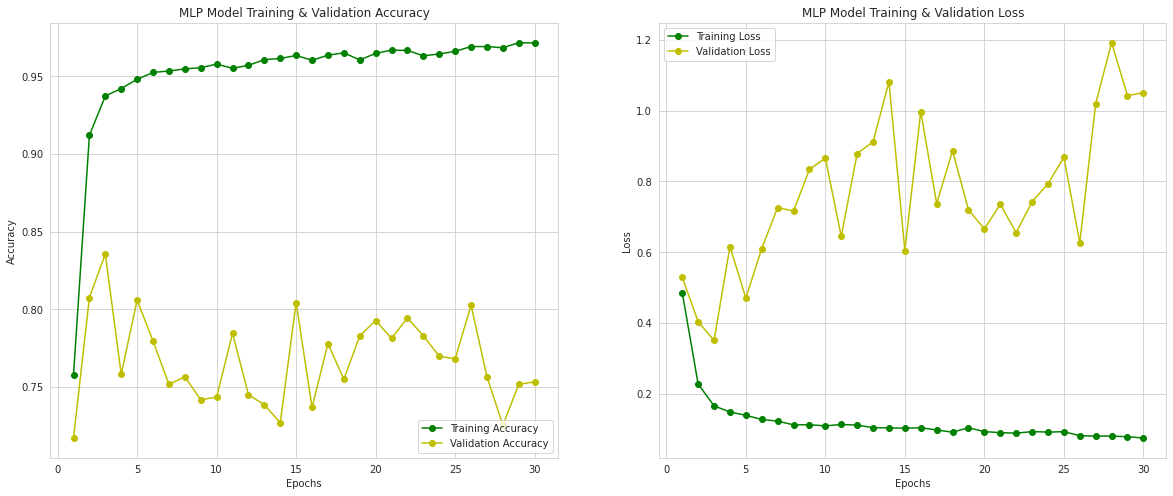

In [25]:
fig , ax = plt.subplots(1,2)
fig.set_size_inches(20, 8)

mlp_train_acc = mlp_history.history['acc']
mlp_train_loss = mlp_history.history['loss']
mlp_val_acc = mlp_history.history['val_acc']
mlp_val_loss = mlp_history.history['val_loss']

epochs = range(1, len(mlp_train_acc) + 1)

ax[0].plot(epochs , mlp_train_acc , 'g-o' , label = 'Training Accuracy')
ax[0].plot(epochs , mlp_val_acc , 'y-o' , label = 'Validation Accuracy')
ax[0].set_title('MLP Model Training & Validation Accuracy')
ax[0].legend(loc = 'lower right')
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , mlp_train_loss , 'g-o' , label = 'Training Loss')
ax[1].plot(epochs , mlp_val_loss , 'y-o' , label = 'Validation Loss')
ax[1].set_title('MLP Model Training & Validation Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")

plt.show()

In [26]:
#save
plt.savefig('mlp_model.png')

<Figure size 432x288 with 0 Axes>

.evaluate() is for evaluating our trained model

In [27]:
print('Train loss & accuracy:' , mlp_model.evaluate(X_train, y_train))
print('\n')
print('Test loss & accuracy:' , mlp_model.evaluate(X_test, y_test))

163/163 [==============================] - 0s 2ms/step - loss: 0.0660 - acc: 0.9760
Train loss & accuracy: [0.06599460542201996, 0.9760352969169617]


20/20 [==============================] - 0s 1ms/step - loss: 1.1213 - acc: 0.7404
Test loss & accuracy: [1.1213278770446777, 0.7403846383094788]


.predict() is for predicting target value, predicted from our test data

In [28]:
from sklearn.metrics import accuracy_score, confusion_matrix, plot_confusion_matrix

#make prediction
yhat_test = mlp_model.predict_classes(X_test)

#get confusion matrix
cm = confusion_matrix(y_test, yhat_test)
print(cm)

[[ 76 158]
 [  4 386]]


/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [29]:
#code from https://www.kaggle.com/basel99/chest-x-ray-images-cnn-handling-overfitting

import itertools
def plot_confusion_matrix(cm, classes,
                          normalize = False,
                          title = 'Confusion matrix',
                          cmap = plt.cm.Blues):
    
    plt.figure(figsize = (6,6))
    plt.imshow(cm, interpolation = 'nearest', cmap = cmap)
    plt.title(title)
    plt.colorbar()
    plt.grid(b = None)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation = 90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]

    thresh = cm.max() / 2.
    cm = np.round(cm,2)
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 fontsize = 12,
                 horizontalalignment = "center",
                 color = "white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

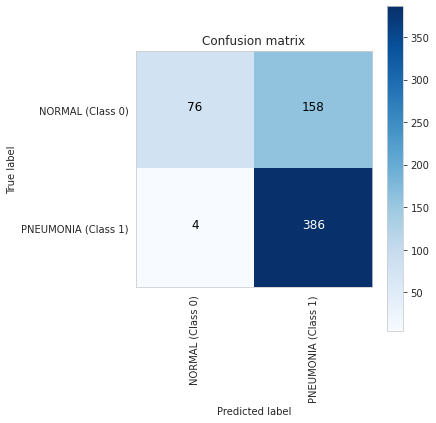

In [30]:
#plot confustion matrix
plot_confusion_matrix(cm, classes = ['NORMAL (Class 0)','PNEUMONIA (Class 1)'], normalize = False)

In [31]:
#save
plt.savefig('mlp_model_cm.png')

<Figure size 432x288 with 0 Axes>

In [32]:
from sklearn.metrics import classification_report

print('Model: Multilayer Perceptron', '\n', classification_report(y_test, yhat_test, target_names = ['NORMAL (Class 0)','PNEUMONIA (Class 1)']))

Model: Multilayer Perceptron 
                      precision    recall  f1-score   support

   NORMAL (Class 0)       0.95      0.32      0.48       234
PNEUMONIA (Class 1)       0.71      0.99      0.83       390

           accuracy                           0.74       624
          macro avg       0.83      0.66      0.66       624
       weighted avg       0.80      0.74      0.70       624



AUC: 0.6572649572649573


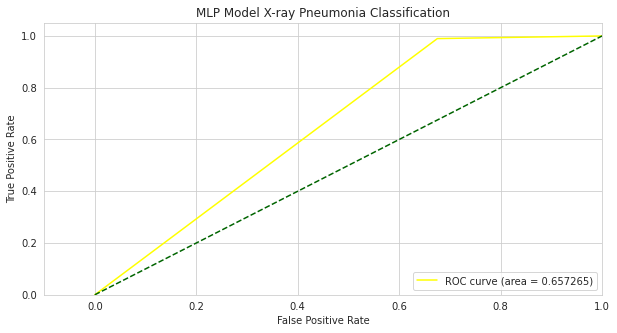

In [33]:
from sklearn.metrics import auc,roc_curve,roc_auc_score

fpr, tpr, thresholds = roc_curve(y_test, yhat_test)
auc = roc_auc_score(y_test, yhat_test)
print('AUC:', auc)

plt.figure(figsize = (10, 5))
plt.plot(fpr, tpr, color = 'yellow', label = 'ROC curve (area = %f)' % auc)
plt.plot([0, 1], [0, 1], linestyle = '--', color = 'darkgreen')
plt.xlim([-0.1, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('MLP Model X-ray Pneumonia Classification')
plt.legend(loc = "lower right")
plt.show()

In [34]:
#save
plt.savefig('mlp_model_roc.png')

<Figure size 432x288 with 0 Axes>

In [35]:
#summary table
summary_table = pd.DataFrame({'Model': [],
                              'Accuracy': [],
                              'Precision': [], 'Recall': [], 'F1 Score': [],
                              'AUC': []})

In [36]:
summary_table.loc[0] = ['Multilayer Perceptron Model',
                        round(accuracy_score(y_test, yhat_test), 2),
                        round(precision_score(y_test, yhat_test, average = 'macro'), 2), round(recall_score(y_test, yhat_test, average = 'macro'), 2), round(f1_score(y_test, yhat_test, average = 'macro'), 2),
                        round(roc_auc_score(y_test, yhat_test), 2)]
summary_table.head()

,Model,Accuracy,Precision,Recall,F1 Score,AUC
0,Multilayer Perceptron Model,0.74,0.83,0.66,0.66,0.66


# Convolutional Neural Network Model (CNN)

In [37]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

#define the callbacks
early_stopping = [EarlyStopping(monitor = 'val_loss', patience = 10, verbose = 1),
                 ModelCheckpoint(filepath = 'cnn_model.h5', monitor = 'val_loss', save_best_only = True)]

In [38]:
from keras.layers import Dropout, Flatten
from keras import regularizers

#build a baseline CNN model
cnn_model = models.Sequential()

cnn_model.add(Conv2D(32, (3, 3), activation = 'relu', input_shape = (150, 150, 3)))
cnn_model.add(MaxPooling2D((2, 2)))

cnn_model.add(Conv2D(32, (3, 3), activation = 'relu'))
cnn_model.add(MaxPooling2D((2, 2)))

#fully connected layer
cnn_model.add(Flatten())
cnn_model.add(Dense(64, activation = 'relu'))
cnn_model.add(Dense(128, activation = 'relu'))

#one layer with sigmoid activation 
cnn_model.add(Dense(1, activation = 'sigmoid'))

In [39]:
#compile
cnn_model.compile(loss = 'binary_crossentropy',
                  optimizer = keras.optimizers.Adam(0.0001),
                  metrics = ['acc'])

In [40]:
#get summary
cnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 41472)             0         
_________________________________________________________________
dense_5 (Dense)              (None, 64)                2654272   
_________________________________________________________________
dense_6 (Dense)              (None, 128)              

In [41]:
start = datetime.datetime.now()

#fit
cnn_history = cnn_model.fit(train_generator,
                            steps_per_epoch = 5216 // 32,
                            epochs = 30,
                            validation_data = test_generator,
                            validation_steps = 624 // 32,
                            callbacks = early_stopping)

Epoch 1/30
163/163 [==============================] - 138s 844ms/step - loss: 0.5721 - acc: 0.7283 - val_loss: 0.5247 - val_acc: 0.7319
Epoch 2/30
163/163 [==============================] - 136s 835ms/step - loss: 0.4059 - acc: 0.8131 - val_loss: 0.4426 - val_acc: 0.7961
Epoch 3/30
163/163 [==============================] - 136s 833ms/step - loss: 0.3467 - acc: 0.8442 - val_loss: 0.3863 - val_acc: 0.8240
Epoch 4/30
163/163 [==============================] - 136s 833ms/step - loss: 0.3252 - acc: 0.8488 - val_loss: 0.4049 - val_acc: 0.8322
Epoch 5/30
163/163 [==============================] - 136s 831ms/step - loss: 0.2952 - acc: 0.8634 - val_loss: 0.3573 - val_acc: 0.8536
Epoch 6/30
163/163 [==============================] - 136s 836ms/step - loss: 0.2568 - acc: 0.8932 - val_loss: 0.3766 - val_acc: 0.8536
Epoch 7/30
163/163 [==============================] - 136s 832ms/step - loss: 0.2655 - acc: 0.8793 - val_loss: 0.3238 - val_acc: 0.8717
Epoch 8/30
163/163 [============================

In [42]:
#time
end = datetime.datetime.now()
elapsed = end - start
print('Training took a total of {}'.format(elapsed))

Training took a total of 1:07:59.877966


In [43]:
#save model
cnn_model.save('cnn_model.h5')

### Model Evaluation

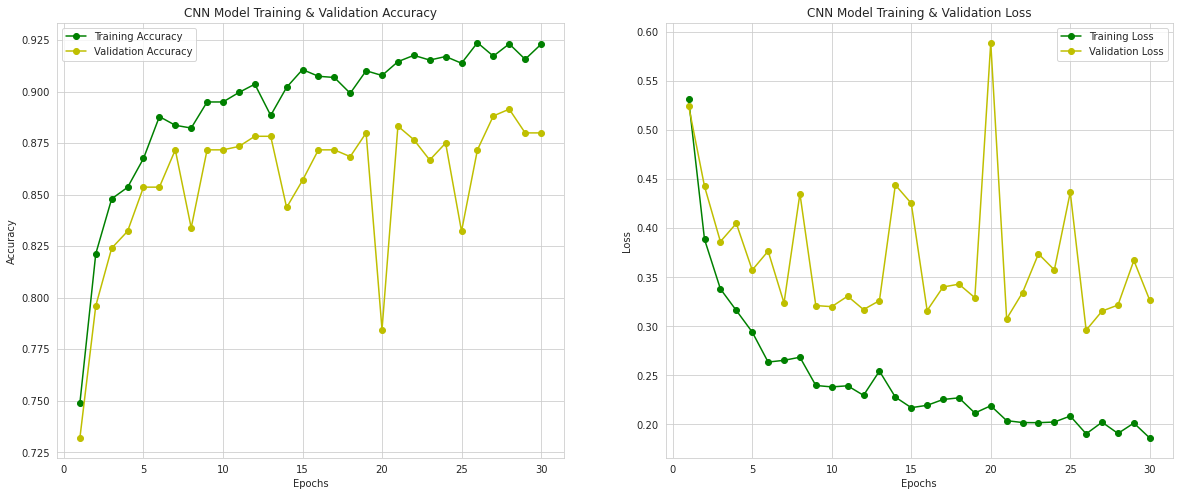

In [44]:
fig , ax = plt.subplots(1,2)
fig.set_size_inches(20, 8)

cnn_train_acc = cnn_history.history['acc']
cnn_train_loss = cnn_history.history['loss']
cnn_val_acc = cnn_history.history['val_acc']
cnn_val_loss = cnn_history.history['val_loss']

epochs = range(1, len(cnn_train_acc) + 1)

ax[0].plot(epochs , cnn_train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , cnn_val_acc , 'yo-' , label = 'Validation Accuracy')
ax[0].set_title('CNN Model Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , cnn_train_loss , 'go-' , label = 'Training Loss')
ax[1].plot(epochs , cnn_val_loss , 'yo-' , label = 'Validation Loss')
ax[1].set_title('CNN Model Training & Validation Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")

plt.show()

In [45]:
#save
plt.savefig('cnn_model.png')

<Figure size 432x288 with 0 Axes>

In [46]:
#evaluate
print('Train loss & accuracy:' , cnn_model.evaluate(train_generator))
print('\n')
print('Test loss & accuracy:' , cnn_model.evaluate(test_generator))

163/163 [==============================] - 98s 598ms/step - loss: 0.1885 - acc: 0.9247
Train loss & accuracy: [0.18849782645702362, 0.9246549010276794]


20/20 [==============================] - 8s 353ms/step - loss: 0.3203 - acc: 0.8830
Test loss & accuracy: [0.3202977180480957, 0.8830128312110901]


/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[[182  52]
 [ 21 369]]


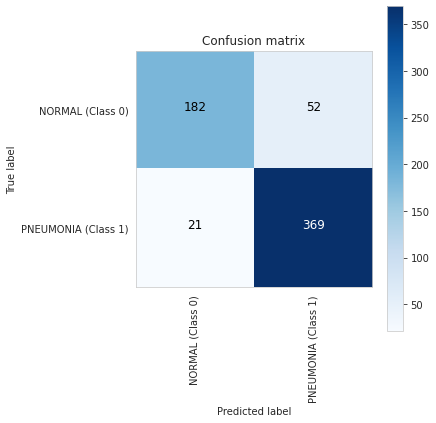

In [47]:
#define target for testing
y_test = test_generator.classes

#make prediction
yhat_test = cnn_model.predict_classes(test_generator)

#get confusion matrix
cm = confusion_matrix(y_test, yhat_test)
print(cm)

#plot confusion matrix
plot_confusion_matrix(cm, classes = ['NORMAL (Class 0)','PNEUMONIA (Class 1)'], normalize = False)

In [48]:
#save
plt.savefig('cnn_model_cm.png')

<Figure size 432x288 with 0 Axes>

In [49]:
#get classification report
print('Model: CNN', '\n', classification_report(y_test, yhat_test, target_names = ['NORMAL (Class 0)','PNEUMONIA (Class 1)']))

Model: CNN 
                      precision    recall  f1-score   support

   NORMAL (Class 0)       0.90      0.78      0.83       234
PNEUMONIA (Class 1)       0.88      0.95      0.91       390

           accuracy                           0.88       624
          macro avg       0.89      0.86      0.87       624
       weighted avg       0.88      0.88      0.88       624



AUC: 0.8619658119658119


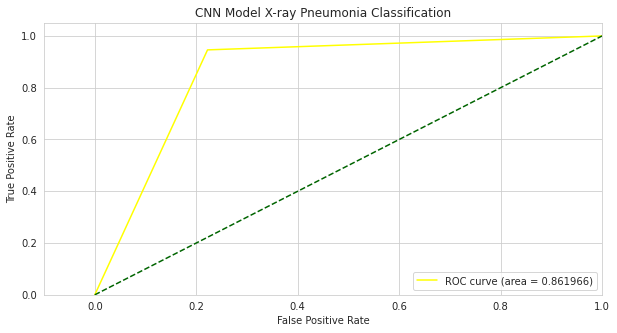

In [50]:
fpr, tpr, thresholds = roc_curve(y_test, yhat_test)
auc = roc_auc_score(y_test, yhat_test)
print('AUC:', auc)

plt.figure(figsize = (10, 5))
plt.plot(fpr, tpr, color = 'yellow', label = 'ROC curve (area = %f)' % auc)
plt.plot([0, 1], [0, 1], linestyle = '--', color = 'darkgreen')
plt.xlim([-0.1, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('CNN Model X-ray Pneumonia Classification')
plt.legend(loc = "lower right")
plt.show()

In [51]:
#save
plt.savefig('cnn_model_roc.png')

<Figure size 432x288 with 0 Axes>

In [52]:
#update summary table
summary_table.loc[1] = ['Convolutional Neural Network Model',
                        round(accuracy_score(y_test, yhat_test), 2),
                        round(precision_score(y_test, yhat_test, average = 'macro'), 2), round(recall_score(y_test, yhat_test, average = 'macro'), 2), round(f1_score(y_test, yhat_test, average = 'macro'), 2),
                        round(roc_auc_score(y_test, yhat_test), 2)]
summary_table.head()

,Model,Accuracy,Precision,Recall,F1 Score,AUC
0,Multilayer Perceptron Model,0.74,0.83,0.66,0.66,0.66
1,Convolutional Neural Network Model,0.88,0.89,0.86,0.87,0.86


# Pretrained CNN Model
Adapting a pretrained model will undoubtedly produce better results than a fresh CNN due to the limited size of training data. We will import a pretrained model VGG-19 to use as the convolutional base. By doing this, we transform the dataset into a rich feature space and add a few fully connected layers on top of the pretrained layers to build a classification model.

In [53]:
#initialize base CNN
from keras.applications import VGG16

cnn_base = VGG16(include_top = False,
                 weights = 'imagenet',
                 input_shape = (150, 150, 3),
                 classes = 2,
                 classifier_activation = 'sigmoid')

58892288/58889256 [==============================] - 1s 0us/step


In [54]:
#leave the pretrained model frozen to prevent the weights in a given layer from being updated during training.
cnn_base.trainable = False

In [55]:
#define model architecture
pretrainedCNN_model = models.Sequential()

pretrainedCNN_model.add(cnn_base)

#fully connected layer
pretrainedCNN_model.add(layers.Flatten())

pretrainedCNN_model.add(Dense(640, activation = 'relu'))
pretrainedCNN_model.add(Dropout(0.5))
pretrainedCNN_model.add(Dense(128, activation = 'relu'))
pretrainedCNN_model.add(Dropout(0.5))

#output layer
pretrainedCNN_model.add(layers.Dense(1, activation = 'sigmoid'))

In [56]:
#check whether a layer is trainable (or alter its setting) 
for layer in pretrainedCNN_model.layers:
    print(layer.name, layer.trainable)

vgg16 False
flatten_1 True
dense_8 True
dropout True
dense_9 True
dropout_1 True
dense_10 True


In [57]:
#compile
pretrainedCNN_model.compile(loss = 'binary_crossentropy',
                            optimizer = keras.optimizers.Adam(0.0001),
                            metrics = ['acc'])

In [58]:
#get summary
pretrainedCNN_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 640)               5243520   
_________________________________________________________________
dropout (Dropout)            (None, 640)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 128)               82048     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 1)                

In [59]:
start = datetime.datetime.now()

#fit
pretrainedCNN_history = pretrainedCNN_model.fit(train_generator,
                                                steps_per_epoch = 5216 // 32,
                                                epochs = 30,
                                                validation_data = test_generator,
                                                validation_steps = 624 // 32,
                                                callbacks = early_stopping)

Epoch 1/30
163/163 [==============================] - 713s 4s/step - loss: 0.4815 - acc: 0.7787 - val_loss: 0.3214 - val_acc: 0.8766
Epoch 2/30
163/163 [==============================] - 713s 4s/step - loss: 0.2668 - acc: 0.8824 - val_loss: 0.2930 - val_acc: 0.8783
Epoch 3/30
163/163 [==============================] - 711s 4s/step - loss: 0.2392 - acc: 0.8980 - val_loss: 0.2835 - val_acc: 0.9013
Epoch 4/30
163/163 [==============================] - 715s 4s/step - loss: 0.2335 - acc: 0.9053 - val_loss: 0.2787 - val_acc: 0.8964
Epoch 5/30
163/163 [==============================] - 723s 4s/step - loss: 0.2062 - acc: 0.9176 - val_loss: 0.2792 - val_acc: 0.9013
Epoch 6/30
163/163 [==============================] - 714s 4s/step - loss: 0.1926 - acc: 0.9213 - val_loss: 0.2611 - val_acc: 0.9046
Epoch 7/30
163/163 [==============================] - 738s 5s/step - loss: 0.2045 - acc: 0.9178 - val_loss: 0.2853 - val_acc: 0.8947
Epoch 8/30
163/163 [==============================] - 722s 4s/step - 

In [60]:
#time
end = datetime.datetime.now()
elapsed = end - start
print('Training took a total of {}'.format(elapsed))

Training took a total of 6:00:20.721855


In [61]:
#save model
pretrainedCNN_model.save('pretrainedCNN_model.h5')

### Model Evaluation

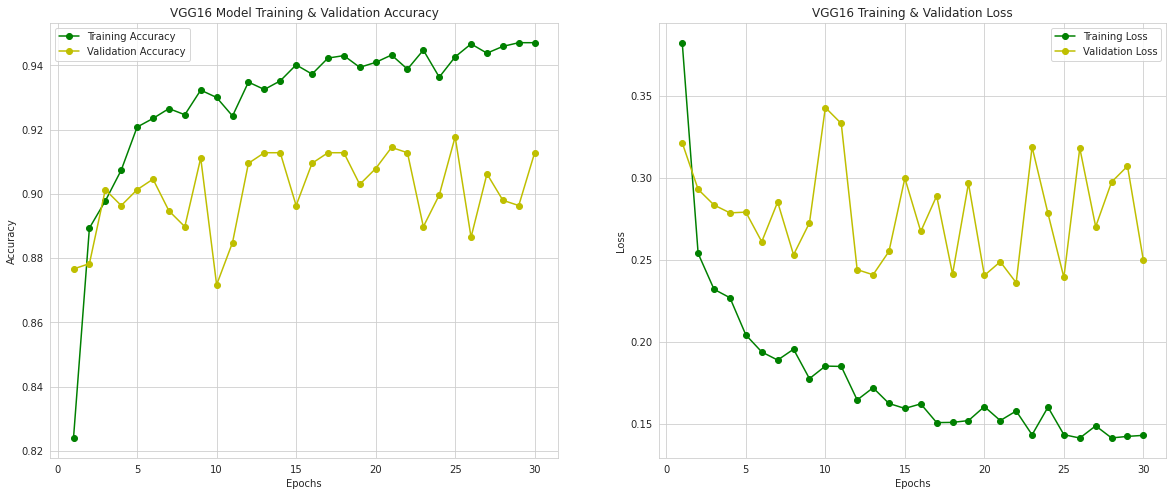

In [62]:
fig , ax = plt.subplots(1,2)
fig.set_size_inches(20, 8)

pretrainedCNN_train_acc = pretrainedCNN_history.history['acc']
pretrainedCNN_train_loss = pretrainedCNN_history.history['loss']
pretrainedCNN_val_acc = pretrainedCNN_history.history['val_acc']
pretrainedCNN_val_loss = pretrainedCNN_history.history['val_loss']

epochs = range(1, len(pretrainedCNN_train_acc) + 1)

ax[0].plot(epochs , pretrainedCNN_train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , pretrainedCNN_val_acc , 'yo-' , label = 'Validation Accuracy')
ax[0].set_title('VGG16 Model Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , pretrainedCNN_train_loss , 'go-' , label = 'Training Loss')
ax[1].plot(epochs , pretrainedCNN_val_loss , 'yo-' , label = 'Validation Loss')
ax[1].set_title('VGG16 Training & Validation Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")

plt.show()

In [63]:
#save
plt.savefig('VGG16_cnn_model.png')

<Figure size 432x288 with 0 Axes>

In [64]:
print('Train loss & accuracy:' , pretrainedCNN_model.evaluate(train_generator))
print('\n')
print('Test loss & accuracy:' , pretrainedCNN_model.evaluate(test_generator))

163/163 [==============================] - 641s 4s/step - loss: 0.1245 - acc: 0.9517
Train loss & accuracy: [0.12452378123998642, 0.9516870975494385]


20/20 [==============================] - 75s 4s/step - loss: 0.2436 - acc: 0.9151
Test loss & accuracy: [0.24364535510540009, 0.9150640964508057]


In [65]:
#make prediction
yhat_test = pretrainedCNN_model.predict_classes(test_generator)

#get confusion matrix
cm = confusion_matrix(y_test, yhat_test)
print(cm)

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[[197  37]
 [ 16 374]]


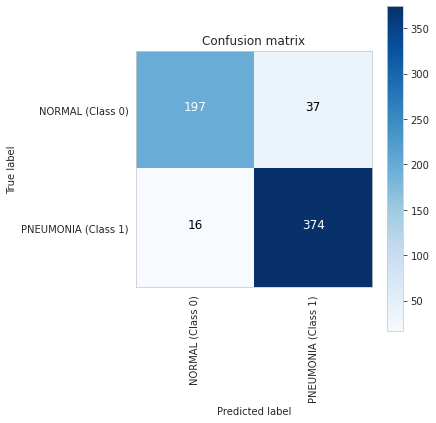

In [66]:
#plot confustion matrix
plot_confusion_matrix(cm, classes = ['NORMAL (Class 0)','PNEUMONIA (Class 1)'], normalize = False)

In [67]:
#save
plt.savefig('VGG16_cnn_model_cm.png')

<Figure size 432x288 with 0 Axes>

In [68]:
#get classification report
print('Model: VGG16 CNN Model', '\n', classification_report(y_test, yhat_test, target_names = ['NORMAL (Class 0)','PNEUMONIA (Class 1)']))

Model: VGG16 CNN Model 
                      precision    recall  f1-score   support

   NORMAL (Class 0)       0.92      0.84      0.88       234
PNEUMONIA (Class 1)       0.91      0.96      0.93       390

           accuracy                           0.92       624
          macro avg       0.92      0.90      0.91       624
       weighted avg       0.92      0.92      0.91       624



AUC: 0.9004273504273504


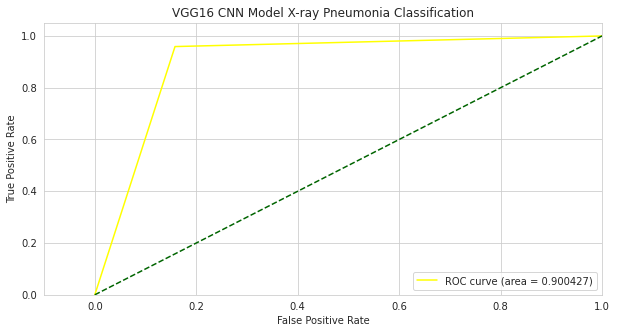

In [69]:
fpr, tpr, thresholds = roc_curve(y_test, yhat_test)
auc = roc_auc_score(y_test, yhat_test)
print('AUC:', auc)

plt.figure(figsize = (10, 5))
plt.plot(fpr, tpr, color = 'yellow', label = 'ROC curve (area = %f)' % auc)
plt.plot([0, 1], [0, 1], linestyle = '--', color = 'darkgreen')
plt.xlim([-0.1, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('VGG16 CNN Model X-ray Pneumonia Classification')
plt.legend(loc = "lower right")
plt.show()

In [70]:
#save
plt.savefig('VGG16_cnn_model_roc.png')

<Figure size 432x288 with 0 Axes>

In [71]:
#update summary table
summary_table.loc[2] = ['Transfer Learning: VGG16 CNN Model',
                        round(accuracy_score(y_test, yhat_test), 2),
                        round(precision_score(y_test, yhat_test, average = 'macro'), 2), round(recall_score(y_test, yhat_test, average = 'macro'), 2), round(f1_score(y_test, yhat_test, average = 'macro'), 2),
                        round(roc_auc_score(y_test, yhat_test), 2)]
summary_table.head()

,Model,Accuracy,Precision,Recall,F1 Score,AUC
0,Multilayer Perceptron Model,0.74,0.83,0.66,0.66,0.66
1,Convolutional Neural Network Model,0.88,0.89,0.86,0.87,0.86
2,Transfer Learning: VGG16 CNN Model,0.92,0.92,0.90,0.91,0.90


In [72]:
#save
summary_table.to_csv('summary_table.csv')